### Dictionary

train_direction = 0 south, 1 north
train_type = 0 Local, 1 Limited, 2 Bullet
train_

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import re
import random
import operator
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from func import *

# inline plot
%matplotlib inline
#%%javascript
#IPython.OutputArea.auto_scroll_threshold = 9999;

In [2]:
#%load 'data/raw-twt2016-01-26-14/21/09.csv'
df = pd.read_csv("data/raw-twt2016-01-26-14-21-09.csv",sep='\t',error_bad_lines=False)
# df.head(5)
print len(df.index)
list(df.columns.values)

3199


['Unnamed: 0',
 'created_at',
 'favorite_count',
 'favorited',
 'hashtags',
 'id',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'media',
 'place',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'urls',
 'user',
 'user_mentions']

Cleanin' the data

In [3]:
# Fill in blank hashtags
df = df.where((pd.notnull(df)), np.nan)
df["hashtags"].fillna('')

# Add some date/time things
df["created_at"] = pd.to_datetime(df["created_at"], errors='coerce')

df["day_of_week"] = df["created_at"].apply(lambda x: x.weekday())
df["day_of_month"] = df["created_at"].apply(lambda x: x.day)
df["month"] = df["created_at"].apply(lambda x: x.month)
df["time_of_day"] = df["created_at"].apply(lambda x: get_time_of_day(x))
# df['in_reply_to_screen_name'].fillna(-1)
# df['in_reply_to_status_id'].fillna(-1)
# df['in_reply_to_user_id'].fillna(-1)
# df['retweeted_status'].fillna(-1)
# df['retweeted'].fillna(-1)
df['retweet_count'].fillna(np.nan)
df['favorite_count'].fillna(np.nan)
df["hashtags"].fillna(np.nan)
df["hashtags"] = df["hashtags"].apply(lambda x: str(x)[1:-1])
df.loc[df["hashtags"]=='a',"hashtags"] = ''
list(df.columns.values)

['Unnamed: 0',
 'created_at',
 'favorite_count',
 'favorited',
 'hashtags',
 'id',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'media',
 'place',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'urls',
 'user',
 'user_mentions',
 'day_of_week',
 'day_of_month',
 'month',
 'time_of_day']

In [4]:
#Potentially remove, just cleaning for analysis sake
del df['Unnamed: 0']
del df['truncated']
del df['user_mentions']
del df['urls']
del df['source']
del df['lang']
del df['place']
del df['favorited']
del df['media']
del df['user']

# More likely to remove
del df['in_reply_to_status_id']
del df['in_reply_to_user_id']
del df['retweeted']
del df['retweeted_status']

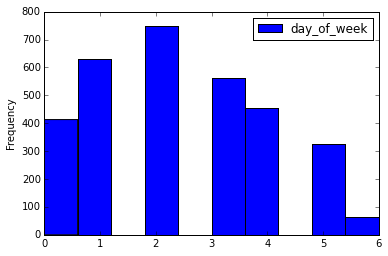

In [5]:
df.plot(x='created_at', y='day_of_week', kind='hist')
# fdf = df[["created_at","id","text","hashtags"]]
# str(fdf

Let's start getting some more detailed data from the trips as well

In [6]:
# df['favorite_count'] = df['favorite_count'].astype(np.int64)
# df['retweet_count'] = df['retweet_count'].astype(np.int64)
# df['text'] = df['text'].astype(str)
# df['id'] = df['id'].astype(np.int64)
# df['day_of_week'] = df['day_of_week'].astype(np.int64)
# df['day_of_month'] = df['day_of_month'].astype(np.int64)
# df['month'] = df['month'].astype(np.int64)
# df['time_of_day'] = df['time_of_day'].astype(np.int64)
df.loc[df["hashtags"]=='on',"hashtags"] = np.nan
df.convert_objects(convert_numeric=True)
df.dtypes

/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


created_at                 datetime64[ns]
favorite_count                    float64
hashtags                           object
id                                  int64
in_reply_to_screen_name            object
retweet_count                     float64
text                               object
day_of_week                         int64
day_of_month                        int64
month                               int64
time_of_day                         int64
dtype: object

In [7]:
# Pull out potential trains from both hashtags and text
df["topic_train"] = df["text"].apply(lambda x: check_hashtag(x))
df["topic_train"] = df["topic_train"].apply(lambda x: str(x)[1:-1])
df["topic_train"].fillna(np.nan)
df.head(5)

,created_at,favorite_count,hashtags,id,in_reply_to_screen_name,retweet_count,text,day_of_week,day_of_month,month,time_of_day,topic_train
0,2016-01-26 20:32:15,6,SanFrancisco,692082643022680064,NaN,7,NOTICE: Ped &amp; Bike detours in place for Ma...,1,26,1,0,
1,2016-01-26 19:41:32,NaN,,692069881559134208,therealwall,NaN,@therealwall After the end of the concert we w...,1,26,1,3,
2,2016-01-26 19:28:52,NaN,SB50,692066695838498816,AemalTheAFGHAN,NaN,@AemalTheAFGHAN @BKDenverSports We're glad to ...,1,26,1,3,'50'
3,2016-01-26 18:12:35,1,"Sorry, Headphones",692047497238175744,4c4d,NaN,"@4c4d Oh man. We love that, too. Our favorite ...",1,26,1,3,
4,2016-01-26 17:53:20,7,,692042650933862401,NaN,18,"Pssst, hey, regular Caltrain riders: expect a ...",1,26,1,3,


In [8]:
# parse_train_id('a123')

In [9]:
# pd.pivot_table(
#   df,values='values',
#   index=['month'],
#   columns=['day_of_week'])

First, a word about the below code.
In the accompanying `func.py` there is a function called parse_train that returns a `pandas.Series` object. For some reason, when it's returned from a map or apply, it seems to get cast as a string. When applied to a list or a dataframe, this string gets turned into a single field in the row, OR divided into several rows, throwing the count off.

To get around this, I return the results of the parse_train function and then CAST it back to a series. This adds a weird 0 index, which I delete. I then fill in the plethora of NaNs and recombine it with the primary dataframe.

For context, previous iterations included
`df['topic_train'].apply(lambda x:parse_train(x))`
which would return a pd.Series object with `str` versions of the returned pd.Series from `parse_train`

In [10]:
ret = []

def parse_train(t):
# x should be a list with train codes eg 123
# {"id": "123", "type:" "bullet", direction: "south"}

    try:
        s = t['topic_train'].split(',')
    except:
        return t['topic_train']
    if s[0] == '':
#         print ""
        return np.nan
    for x in s:
#         print "Iter",x[1:-1]
        q = {}
        # Check train id
#         x = parse_train_id(x)
        x = str(x)
        x = str(x[1:-1])
        if len(x)<3: continue

        # 1 = north, 0 = south
        q["direction"] = 1 if int(x[2]) in [1,3,5,7,9] else 0

        if x[0] == '1':
            q["type"] = 0 # local
        elif x[0] == '2':
            q["type"] = 1 # limited
        elif x[0] == '3':
            q["type"] = 2 # bullet
        else:
            q["type"] = -1
        ret.append({'tweet_id': t['id'],'timestamp': t['created_at'], 'train_id':x, 'train_direction':q["direction"], 'train_type': q["type"] })
    return s

In [11]:
# Let's then filter those train topics into details
# Btw this is jank as fuck.

# red = df[['id','created_at','topic_train']]
red = df.apply(lambda x:parse_train(x),axis=1)
#red
tf = pd.DataFrame(ret)
tf.head(5)

#events = pd.DataFrame([pd.Series(x) for x in red.apply(parse_train)])
#events
#del new.iloc[0]
#new.fillna('')
#df.combine_first(new)

,timestamp,train_direction,train_id,train_type,tweet_id
0,2016-01-25 23:42:14,1,155,0,691768068385718275
1,2016-01-20 22:22:55,1,151,0,689936168893329408
2,2016-01-19 18:08:25,0,138,0,689509733640732672
3,2016-01-19 16:32:04,0,216,1,689485484838416388
4,2016-01-19 16:32:04,0,'225,-1,689485484838416388


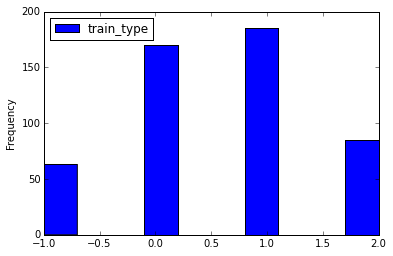

In [20]:
tf.plot(x='timestamp',y='train_type',kind='hist',xlim=[-1,2])

In [13]:
len(tf)

503

In [14]:
df = df.merge(tf, left_on='id',right_on='tweet_id',how='right')

In [21]:
df.groupby(['time_of_day','month']).mean()

favorite_count            id  retweet_count  day_of_week  \
time_of_day month                                                             
0           1            1.722222  6.868363e+17       3.333333     2.416667   
            6            1.214286  6.126870e+17       1.970588     3.500000   
            7            2.437500  6.221890e+17       3.700000     2.600000   
            8            2.350000  6.335719e+17       3.022727     2.840909   
            9            2.777778  6.439176e+17       3.909091     2.314286   
            10           1.857143  6.527556e+17       4.622222     2.688889   
            11           2.578947  6.652454e+17       3.193548     1.531250   
            12           1.666667  6.744306e+17       2.388889     3.684211   
1           10           1.000000  6.520161e+17       1.000000     3.000000   
2           1            1.000000  6.872953e+17       6.000000     2.000000   
            6            1.000000  6.114410e+17       1.571429     1.714286   
            7            2.333333  6.223477e+17       5.800000     1.300000   
            8                 NaN  6.354725e+17       2.000000     2.500000   
            9            1.714286  6.438314e+17       6.250000     2.833333   
            10           2.000000  6.525711e+17       4.000000     3.000000   
            12                NaN  6.722558e+17       4.500000     2.500000   
3           1            1.800000  6.875827e+17       3.500000     1.300000   
            6            2.000000  6.118246e+17       1.555556     1.333333   
            7            1.333333  6.228776e+17       2.000000     1.736842   
            8            1.400000  6.352651e+17       2.428571     2.285714   
            9            2.000000  6.447491e+17       1.640000     1.840000   
            10           1.250000  6.529508e+17       2.210526     2.210526   
            11           1.200000  6.663183e+17       4.100000     0.700000   
            12           1.800000  6.740357e+17       3.700000     1.700000   

                   day_of_month  train_direction  train_type      tweet_id  
time_of_day month                                                           
0           1         11.958333         0.458333    0.666667  6.868363e+17  
            6         21.382353         0.294118    0.823529  6.126870e+17  
            7         17.700000         0.550000    1.100000  6.221890e+17  
            8         17.931818         0.250000    0.613636  6.335719e+17  
            9         15.514286         0.671429    0.571429  6.439176e+17  
            10         9.866667         0.422222    0.466667  6.527556e+17  
            11        13.156250         0.406250    0.343750  6.652454e+17  
            12         8.842105         0.421053    0.631579  6.744306e+17  
1           10         8.000000         1.000000    0.000000  6.520161e+17  
2           1         13.000000         1.000000    0.000000  6.872953e+17  
            6         17.714286         0.714286    1.142857  6.114410e+17  
            7         17.800000         0.400000    1.100000  6.223477e+17  
            8         23.000000         0.500000    1.500000  6.354725e+17  
            9         15.083333         0.833333    0.833333  6.438314e+17  
            10         9.166667         0.500000    0.500000  6.525711e+17  
            12         2.500000         1.000000    1.000000  6.722558e+17  
3           1         13.700000         0.300000    0.100000  6.875827e+17  
            6         18.666667         0.555556    0.666667  6.118246e+17  
            7         19.157895         0.526316    0.526316  6.228776e+17  
            8         22.285714         0.785714    0.071429  6.352651e+17  
            9         17.520000         0.800000    0.360000  6.447491e+17  
            10        10.157895         0.684211    0.210526  6.529508e+17  
            11        16.000000         0.900000    0.300000  6.663183e+17  
            12         7.300000        

In [16]:
list(df.columns.values)

['created_at',
 'favorite_count',
 'hashtags',
 'id',
 'in_reply_to_screen_name',
 'retweet_count',
 'text',
 'day_of_week',
 'day_of_month',
 'month',
 'time_of_day',
 'topic_train',
 'timestamp',
 'train_direction',
 'train_id',
 'train_type',
 'tweet_id']

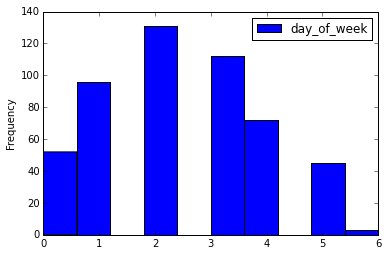

In [17]:
df.plot(x='time_of_day',y='day_of_week',kind='hist')

/Users/albarron/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


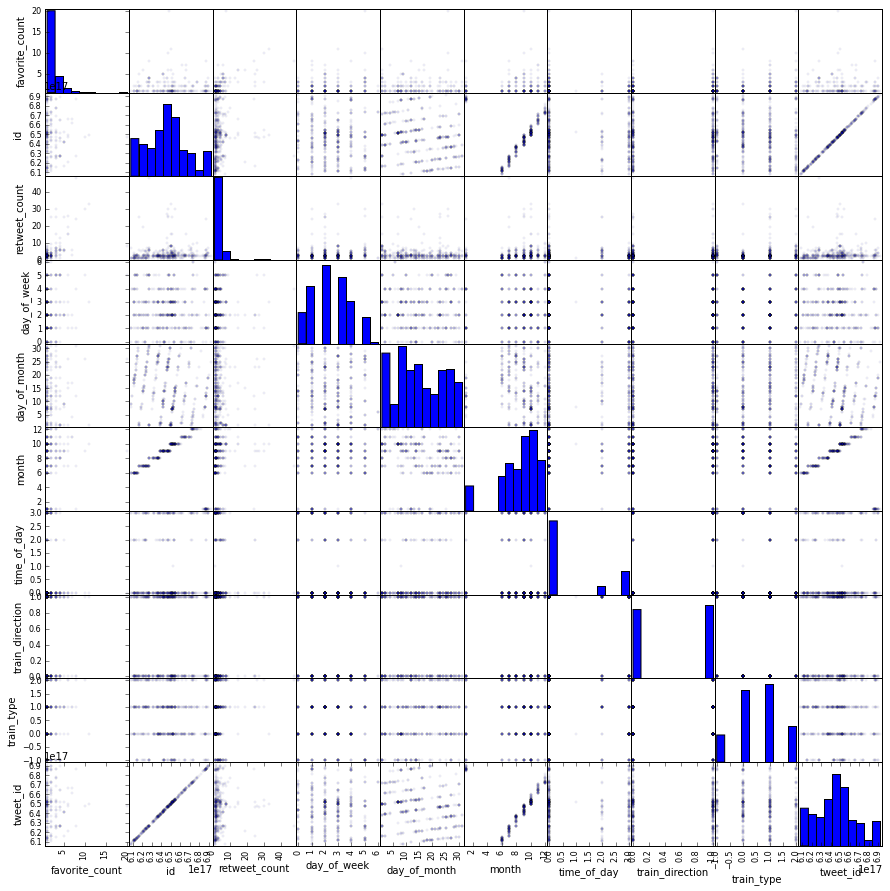

In [18]:
pd.scatter_matrix(df,alpha=0.05,figsize=(15,15), diagonal='hist');

In [19]:
df.groupby('month').describe()

day_of_month  day_of_week  favorite_count            id  \
month                                                                  
1     count     36.000000    36.000000       30.000000  3.600000e+01   
      mean      12.500000     2.083333        1.700000  6.870691e+17   
      std        4.705620     1.480830        1.417866  1.706440e+15   
      min        4.000000     0.000000        1.000000  6.840946e+17   
      25%        8.000000     1.000000        1.000000  6.855573e+17   
      50%       12.000000     1.000000        1.000000  6.867468e+17   
      75%       15.000000     4.000000        2.000000  6.878010e+17   
      max       25.000000     4.000000        8.000000  6.917681e+17   
6     count     50.000000    50.000000       16.000000  5.000000e+01   
      mean      20.380000     2.860000        1.250000  6.123573e+17   
      std        5.612995     1.726268        0.577350  2.005070e+15   
      min        8.000000     0.000000        1.000000  6.079546e+17   
      25%       18.000000     1.250000        1.000000  6.115549e+17   
      50%       20.000000     3.000000        1.000000  6.120650e+17   
      75%       24.750000     4.000000        1.000000  6.140278e+17   
      max       30.000000     5.000000        3.000000  6.156911e+17   
7     count     69.000000    69.000000       25.000000  6.900000e+01   
      mean      18.115942     2.173913        2.160000  6.224016e+17   
      std        9.031866     1.316820        1.772005  3.280239e+15   
      min        1.000000     0.000000        1.000000  6.160466e+17   
      25%       14.000000     1.000000        1.000000  6.207510e+17   
      50%       20.000000     2.000000        2.000000  6.231497e+17   
      75%       25.000000     3.000000        2.000000  6.247452e+17   
      max       31.000000     5.000000        8.000000  6.272640e+17   
8     count     60.000000    60.000000       25.000000  6.000000e+01   
      mean      19.116667     2.700000        2.160000  6.340303e+17   
      std        9.449404     1.597668        1.280625  3.487152e+15   
      min        1.000000     0.000000        1.000000  6.272702e+17   
      25%       13.000000     1.000000        1.000000  6.316357e+17   
      50%       24.000000     3.000000        2.000000  6.359383e+17   
...                   ...          ...             ...           ...   
9     std        9.084790     1.355189        3.257780  3.272499e+15   
      min        1.000000     0.000000        1.000000  6.385084e+17   
      25%        9.000000     1.000000        1.000000  6.414256e+17   
      50%       15.000000     2.000000        1.000000  6.438866e+17   
      75%       23.500000     3.000000        3.000000  6.469518e+17   
      max       30.000000     5.000000       20.000000  6.493411e+17   
10    count    116.000000   116.000000       49.000000  1.160000e+02   
      mean       9.862069     2.629310        1.795918  6.527716e+17   
      std        7.033951     1.130834        1.731805  2.555516e+15   
      min        1.000000     0.000000        1.000000  6.496141e+17   
      25%        7.000000     2.000000        1.000000  6.515610e+17   
      50%        8.000000     3.000000        1.000000  6.520133e+17   
      75%       14.000000     3.000000        2.000000  6.541057e+17   
      max       30.000000     5.000000       11.000000  6.602246e+17   
11    count     42.000000    42.000000       24.000000  4.200000e+01   
      mean      13.833333     1.333333        2.291667  6.655008e+17   
      std        8.826006     1.223084        1.921937  3.173528e+15   
      min        2.000000     0.000000        1.000000  6.612370e+17   
      25%        6.750000     0.000000        1.000000  6.629834e+17   
      50%       12.000000     1.000000        1.500000  6.649104e+17   
      75%       21.500000     2.000000        2.250000  6.683075e+17   
      max       30.000000     4.000000        7.000000  6.713959e+17   
12    count     31.000000    31.000000       14.00000

In [39]:
df[df['train_id'] > 0].groupby('day_of_week').count()

,created_at,favorite_count,hashtags,id,in_reply_to_screen_name,retweet_count,text,day_of_month,month,time_of_day,topic_train,timestamp,train_direction,train_id,train_type,tweet_id
day_of_week,,,,,,,,,,,,,,,,
0,52,25,52,52,0,47,52,52,52,52,52,52,52,52,52,52
1,96,44,96,96,0,96,96,96,96,96,96,96,96,96,96,96
2,131,58,131,131,0,131,131,131,131,131,131,131,131,131,131,131
3,112,44,112,112,0,112,112,112,112,112,112,112,112,112,112,112
4,72,24,72,72,0,72,72,72,72,72,72,72,72,72,72,72
5,45,30,45,45,0,45,45,45,45,45,45,45,45,45,45,45
6,3,3,3,3,0,2,3,3,3,3,3,3,3,3,3,3


In [40]:
df[df['train_id'] > 0].groupby('month').count()

,created_at,favorite_count,hashtags,id,in_reply_to_screen_name,retweet_count,text,day_of_week,day_of_month,time_of_day,topic_train,timestamp,train_direction,train_id,train_type,tweet_id
month,,,,,,,,,,,,,,,,
1,36,30,36,36,0,36,36,36,36,36,36,36,36,36,36,36
6,50,16,50,50,0,50,50,50,50,50,50,50,50,50,50,50
7,69,25,69,69,0,69,69,69,69,69,69,69,69,69,69,69
8,60,25,60,60,0,60,60,60,60,60,60,60,60,60,60,60
9,107,45,107,107,0,103,107,107,107,107,107,107,107,107,107,107
10,116,49,116,116,0,116,116,116,116,116,116,116,116,116,116,116
11,42,24,42,42,0,41,42,42,42,42,42,42,42,42,42,42
12,31,14,31,31,0,30,31,31,31,31,31,31,31,31,31,31
